[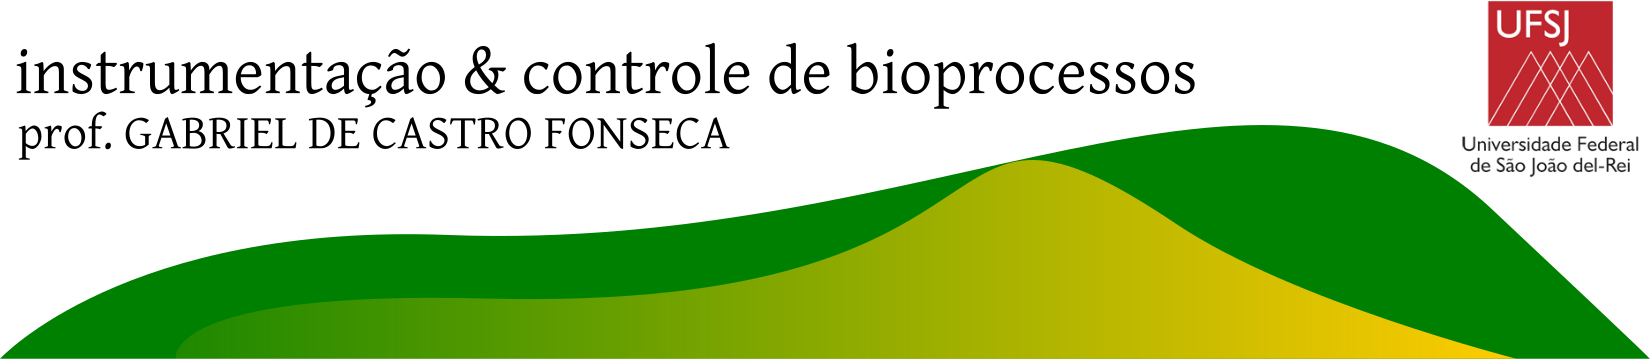](Aulas-Sumário.ipynb)

# Projeto e sintonia de controladores I

*Prof. Gabriel de Castro Fonseca (DQBIO/UFSJ)*<br>
*Instrumentação e Controle de Bioprocessos*

Este documento é publicado sob os termos da licença [GNU General Public Licence 3.0](https://www.gnu.org/licenses/gpl-3.0.en.html).

## Critérios de desempenho

Nas últimas aulas estudamos controladores PID em malhas de realimentação e observamos como a escolha dos parâmetros de controle, $K_c$, $\tau_I$ e $\tau_D$, afeta o desempenho e até a estabilidade do sistema. Na aula de hoje estudaremos os procedimentos para escolha desses parâmetros, isto é, a **sintonia** de um controlador.

Evidentemente, o objetivo da sintonia é escolher o conjunto de parâmetros que garante a melhor resposta possível para o sistema. Entretanto, não podemos definir o que significa exatamente "melhor resposta possível" sem estabelecer alguns critérios.

**Critérios de desempenho** desejáveis poderiam ser, por exemplo,

* Resposta em malha fechada estável.
* Minimização do efeito das perturbações.
* Resposta rápida e suave a mudanças no valor desejado.
* Sem erro estacionário.
* Robustez, isto é, pouca sensibilidade a erros no modelo (por exemplo, efeitos de não-linearidades que não sejam contempladas pelo modelo linearizado).

Infelizmente, nem sempre é possível se satisfazer simultaneamente a todos esses critérios, pois alguns deles são mutuamente contraditórios. Por exemplo o projeto de um controlador mais robusto afeta negativamente a rapidez da resposta. Ou ainda, o conjunto de parâmetros que melhor compensa o efeito de distúrbios não ser o que melhor responde a mudanças no *set-point* e vice-versa.

Assim, não existe uma única resposta para problemas de sintonia de controladores. É papel do engenheiro a cada projeto compreender que critérios são mais críticos e que critérios podem ser sacrificados para melhor controlar o processo.

## Método de Ziegler-Nichols

O método de Ziegler-Nichols é o mais antigo conhecido. Trata-se de um método empírico que visava sistematizar os procedimentos de tentativa e erro, que até hoje são usados ocasionalmente. Atualmente há muitas variantes do MZN com desempenho melhor do que o método original, mas ele ainda é estudado por motivos históricos e por servir como base para essas alternativas mais modernas.

O método de Ziegler-Nichols se baseia nos seguintes passos:

1. Aplique um estímulo degrau sobre o valor desejado do sistema.

2. Usando apenas o controle proporcional, aumente $K_c$ até obter uma resposta em malha fechada oscilatória com amplitde constante (limiar da instabilidade).

3. O valor de $K_c$ alcançado é chamado de **ganho último**, $K_{cu}$. O valor do período de oscilação pico a pico é conhecido como **período último**, $T_u$.

4. Sintonize o controlador utilizado (P, PI ou PID) usando os valores tabelados:

| Tipo | $~~~~~~~~~~K_c~~~~~$ | $~~~~~\tau_I~~~~~$ | $~~~~~\tau_D~~~~~$ |
|:---:|:---:|:---:|:---:|
| P   | $\frac{1}{2} K_{cu}$ |  |  |
| PI  | $\frac{9}{20} K_{cu}$ | $\frac{5}{6} T_u  $ | |
| PID | $\frac{3}{5} K_{cu}$ | $\frac{1}{2} T_u$ | $\frac{1}{8} T_u$ |

Geralmente o que muda nos métodos derivados de Ziegler-Nichols é apenas o passo 4, ou seja, a tabela proposta é diferente. Por exemplo, o método de **Tyreus-Luyben** propõe

| Tipo | $~~~~~~~~~~K_c~~~~~$ | $~~~~~\tau_I~~~~~$ | $~~~~~\tau_D~~~~~$ |
|:---:|:---:|:---:|:---:|
| PI  | $\dfrac{K_{cu}}{3.2} $ | $2.2 T_u  $ | |
| PID | $\dfrac{K_{cu}}{2.2}$ | $2.2 T_u$ | $\dfrac{T_u}{6.3} $ |

### Exemplo:

Vamos sintonizar um sistema de controle PID em realimentação para um sistema com a seguinte função de transferência em malha aberta (Bequette, Exemplo 6.1):

$$
    G(s) = \frac{1}{(3s+1)(2s+1)(s+1)} = \frac{1}{6s^3+11s^2+6s+1} \\
$$

Ou, na forma de uma equação diferencial,

$$
    6\, \dddot y + 11\, \ddot y + 6\, \dot y + y = m(t)
$$

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.integrate import odeint

plt.rcParams["figure.figsize"]=[7,5]
plt.rcParams.update({'font.size': 14})

In [42]:
def sist_mf(t,Kc,τi,τd,bias = 0):
    Km = 1
    Kf = 1
    Kd = 1
    a = [1,6,11,6]
    def eqdif(y,t,d,sp):
        y,dy,d2y,ie,iea = y #ie: integral do erro, iea: integral do erro absoluto
        e = sp - y 
        ea = abs(sp-y)
        d3y = 1/a[3]* ( Kd*d + Km*Kf*(Kc*e+Kc*(ie/τi if τi != 0 else 0) + bias) \
                - a[2]*d2y - (a[1]+τd*Km*Kf*Kc)*dy - a[0]*y )
        return dy, d2y, d3y, e, ea
    y = odeint(eqdif,[0.0]*5,t,args=(0,1))
    iea = y[-1,-1]
    dy = y[:,1]
    y = y[:,0]
    return y, dy, iea

def indices_dos_zeros(array):
    n = len(array)
    indices = []
    for i in range(1,n):
        if np.sign(array[i]) != np.sign(array[i-1]):
            indices += [i] if array[i] < array[i-1] else [i-1]
    return indices

def principal(Kc,τi,τd):
    t = np.linspace(0,20,201)

    y, dy, iea = sist_mf(t,Kc,τi,τd)
    plt.plot(t,y)
    plt.xlabel("tempo, $t$")
    plt.ylabel("resposta em malha fechada, $y(t)$")
    plt.grid()
    try:
        tz = t[indices_dos_zeros(dy)]
        Tu = tz[3]-tz[1]
        print(f"O período vale {Tu:.2f} unidades de tempo.")
    except:
        pass
    print(f"A integral do erro absoluto vale {iea:.5f}.")
    
Kc_widget = widgets.FloatSlider(min=3, max=12, step=.5, value=7.5, description = r'$K_c$')
τi_widget = widgets.FloatSlider(min=0, max=15, step=1, value=0, description = r'$\tau_I$')
τd_widget = widgets.FloatSlider(min=0, max=3, step=.25, value=0, description = r'$\tau_D$')
w = widgets.interact(principal, Kc = Kc_widget, τi = τi_widget, τd = τd_widget)
w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=7.5, description='$K_c$', max=12.0, min=3.0, step=0.5), FloatSlider(va…

<function __main__.principal(Kc, τi, τd)>

A integral do erro absoluto é um possível critério de desempenho do controlador.

$$
    IEA = \int_0^t |e(t)| dt
$$

Quanto menor o valor da IEA, menor o valor do erro acumulado ao longo do tempo.

No exemplo acima, pode-se observar que $K_{cu} = 10$ e $T_u = 6.3$.

Pelo método de Ziegler-Nichols sintoniza-se o PID com os valores $K_c = 6$, $\tau_I \approx 3$ e $\tau_D \approx 0.75$. Nesse caso, $IEA \approx 4.34 $.

Pelo método de Tyreus-Luyben os valores sintonizados são $K_c = 4.5$, $\tau_I \approx 14 $ e $\tau_D = 1$. Assim, $IEA \approx 2.91$, o que indica uma sintonia melhor do ponto de vista da IEA. Oberve que isso não necessariamente quer dizer que essa é a melhor sintonia possível!

A figura abaixo mostra como computar a IEA usando o Xcos:

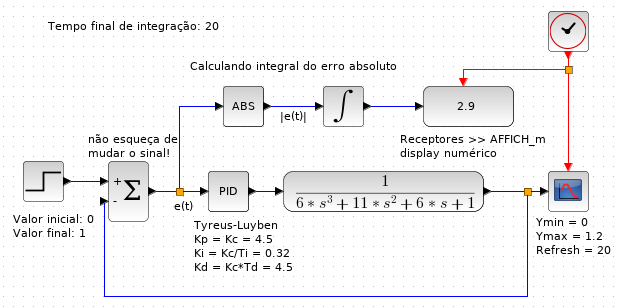

## Método de Cohen-Coon

O método de Cohen-Coon é outro método empírico, mas se baseia na resposta em malha aberta, e não na resposta em malha fechada.

O procedimento consiste em desconectar a malha de controle e aplicar um degrau conhecido diretamente sobre a variável manipulada.

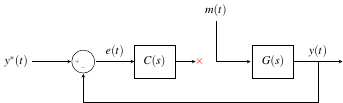

A resposta dinâmica do sistema, conhecida como **curva de reação** é medida e ajustada a um modelo empírico de primeira ordem com tempo morto.

$$
    \frac{y(t)}{u(t)} \approx \frac{Ke^{-s\theta}}{\tau s + 1}
$$

$$
    y(t) \approx aK(1-e^{-(t-\theta)/\tau})\mathbf{1}^+(t-\theta)
$$

Abaixo ilustra-se o método de Cohen-Coon para o mesmo sistema dinâmico que usamos no exemplo anterior.

$$
    G(s) = \frac{1}{6s^3+11s^2+6s+1}
$$

Parâmetros do modelo de 1ª ordem com tempo morto:
θ = 1.87
K = 1.04
τ = 4.75


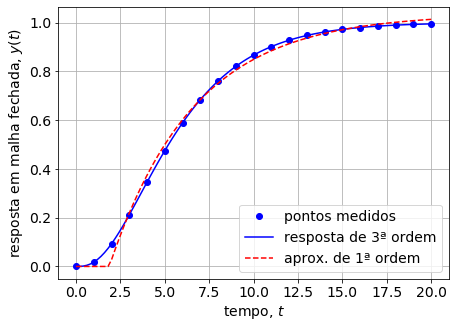

In [2]:
from scipy.optimize import curve_fit

def sist_ma(t):
    Km = 1
    Kf = 1
    Kd = 1
    a = [1,6,11,6]
    def eqdif(y,t,d,m):
        y,dy,d2y = y #ie: integral do erro, iea: integral do erro absoluto
        d3y = 1/a[3]* ( Kd*d + Km*m - a[2]*d2y - a[1]*dy - a[0]*y )
        return dy, d2y, d3y
    y = odeint(eqdif,[0.0]*3,t,args=(0,1))
    y = y[:,0]
    return y

def modelo(t,θ,K,τ):
    t = np.array(t) # t inicialmente é uma lista
    return np.where( t >= θ, K*( 1 - np.exp( -(t-θ)/τ ) ), 0 )

def principal():
    t = np.linspace(0,20,101)
    y = sist_ma(t)
    
    par, covar = curve_fit(modelo,t,y) # parâmetros ajustados e covariância
    θ,K,τ = par
    z = modelo(t,θ,K,τ)
    
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t[0::5],y[0::5],'bo', label = "pontos medidos")
    plt.plot(t,y,'b', label = "resposta de 3ª ordem")
    plt.plot(t,z,'r--', label = "aprox. de 1ª ordem")
    plt.xlabel("tempo, $t$")
    plt.ylabel("resposta em malha fechada, $y(t)$")
    plt.grid()
    plt.legend()
    print("Parâmetros do modelo de 1ª ordem com tempo morto:")
    print(f"θ = {θ:.2f}")
    print(f"K = {K:.2f}")
    print(f"τ = {τ:.2f}")
    return θ, K, τ
    
θ, K, τ = principal()

Com os valores de $\theta$, $K$ e $\tau$ que melhor aproximam a curva de reação nós calculamos os parâmetros do controlador conforme mostra a tabela:

| Tipo | $~~~~~~~K_c~~~~~~$ | $~~~~~~\tau_I~~~~~~$ | $~~~~~~\tau_D~~~~~~$ |
|:---:|:---:|:---:|:---:|
| P   | $\dfrac{\tau}{K\theta}\left( 1 + \dfrac{\theta}{3\tau} \right)$ | $\phantom{aaaaaaaaaaaa}$ |  |
| PI  | $\dfrac{\tau}{K\theta}\left( 0.9 + \dfrac{\theta}{12\tau} \right)$ | $ \dfrac{\theta\left(30 + \dfrac{3\theta}{\tau}\right)}{9+\dfrac{20\theta}{\tau}}  $ | |
| PID | $\dfrac{\tau}{K\theta}\left( \dfrac{4}{3} + \dfrac{\theta}{4\tau} \right)$ | $\dfrac{\theta\left(32 + \dfrac{6\theta}{\tau}\right)}{13+\dfrac{8\theta}{\tau}}$ | $\dfrac{4\theta}{11+\dfrac{2\theta}{\tau}}$ |

Projetando um controlador PID para o sistema a partir desses parâmetros:

In [3]:
Kc = τ/K/θ * ( 4/3 + θ/4/τ )
τi = θ * ( 32 + 6*θ/τ ) / ( 13 + 8*θ/τ )
τd = 4*θ / ( 11 + 2*θ/τ )

print(f"Kc = {Kc:.2f}")
print(f"τi = {τi:.2f}")
print(f"τd = {τd:.2f}")

Kc = 3.51
τi = 3.98
τd = 0.63


Podemos voltar ao gráfico interativo criado anteriormente e substituir valores próximos a esses.

Com $K_c = 3.5$, $\tau_I = 4.0$ e $\tau_D = 0.75$ encontramos $IEA = 3.96$.

## Método da síntese direta

O método da síntese direta consiste em "forçar" um comportamento desejado à função de transferência em malha fechada e verificar que valores dos parâmetros do controlador levam a essa resposta.

Para este método, vamos usar como exemplo um sistema capacitivo com tempo morto.

$$
G(s) = \frac{Ke^{-\theta s}}{\tau s+1} 
$$

Esse sistema foi estudado [há algumas aulas](estabilidade.ipynb).

Considerando $F(s) = T(s) = 1$, a função de transferência do problema servo pode ser escrita como

$$
    S(s) = \frac{G(s)C(s)}{1 + G(s)C(s)}
$$

Isolando $C(s)$:

$$
    C(s) = \frac{S(s)}{G(s)\cdot(1-S(s))}
$$

No método da síntese direta nós escolhemos a resposta desejada para o sistema servo. Por exemplo, suponha que queremos uma resposta capacitiva do tipo

$$
    S(s) = \frac{1}{\lambda s + 1}
$$

onde $\lambda$ é a constante de tempo desejada da resposta. Trata-se de um parâmetro ajustável.

Substituindo $G(s)$ e $C(s)$ na equação, encontramos a forma que $C(s)$ deve ter.

\begin{gather*}
C(s) = \frac{\dfrac{1}{\lambda s + 1}}{\dfrac{Ke^{-\theta s}}{\tau s+1} \left( 1 - \dfrac{1}{\lambda s + 1} \right) } \\
C(s) = \frac{1}{ \dfrac{Ke^{-\theta s}}{\tau s+1} \left(\lambda s + 1 -1 \right) } \\
C(s) = \frac{\tau s + 1}{K\lambda s} e^{+s\theta} \\
C(s) = \frac{\tau}{K\lambda}\left(\frac{\tau s+1}{\tau s}\right)e^{\theta s}
\end{gather*}

Observe que, exceto pelo termo exponencial, a função de transferência $C(s)$ encontrada se parece muito com a função de transferência de um sistema de controle PI com $K_c = \frac{\tau}{K\lambda}$ e $\tau_I = \tau$:

$$
    C(s) = K_c\left( 1 + \frac{1}{\tau_Is} \right) = K_c \left( \frac{\tau_Is + 1}{\tau_Is} \right)
$$

Infelizmente o termo exponencial torna nosso ajuste *irrealizável*. Lembre-se de que $e^{-\theta s}$ representa um atraso de $\theta$ unidades de tempo entre o estímulo e a resposta. Por outro lado, $e^{+\theta s}$ representaria uma resposta adiantada em $\theta$ unidades de tempo em relação ao estímulo mas isso implicaria em um sistema de controle capaz de prever o futuro!

Nossa síntese direta falhou neste caso porque o tipo de resposta servo $S(s) = \frac{1}{\lambda s + 1}$ que tentamos impor não é capaz de compensar o tempo morto. Vamos fazer uma segunda tentativa, dessa vez impondo uma resposta que contém um tempo morto.

\begin{gather*}
    S(s) = \frac{e^{-\theta s}}{\lambda s + 1} \\[3mm]
    C(s) = \frac{ \dfrac{e^{-\theta s}}{\lambda s + 1}}{\dfrac{Ke^{-\theta s}}{\tau s + 1} \left(1 - \dfrac{e^{-\theta s}}{\lambda s + 1} \right) } \\
    C(s) = \frac{\tau s + 1}{K (\lambda s + 1 - e^{-\theta s})}
\end{gather*}

Para valores pequenos de $\theta$ é possível fazer a aproximação por série de potências $e^{-\theta s} \approx 1 - \theta s$ (uma aproximação de Padé também seria possível).

$$
    C(s) = \frac{\tau s + 1}{K (\lambda + \theta) s}
$$

Ou seja, podemos sintonizar um controlador PI considerado $K_c = \frac{\tau}{K(\lambda + \theta)}$ e $\tau_I = \tau$.

No exemplo numérico abaixo consideramos $K = 1$ e $\tau = 1$, deixando apenas $\theta$ e $\lambda$ variarem.

In [44]:
def sist_1otm(t,θ,λ):
    Km = 1
    Kf = 1
    τ  = 1
    Kc = τ/Km/(λ+θ)
    τi = τ
    τd = 0
    K = Km*Kf*Kc
    a = [
            1,
            τ+θ/2+θ**2/12/τi*K - θ/2*K + τd*K,
            θ**2/12+τ*θ/2+θ**2/12*K-θ/2*τd*K,
            θ**2/12*(τ+τd*K)
        ]
    def eqdif(y,t,d,sp):
        y,dy,d2y,ie,iea = y #ie: integral do erro, iea: integral do erro absoluto
        e = sp - y 
        ea = abs(sp-y)
        d3y = 1/a[3]* ( K*e*(1-θ/2/τi) + K*ie/τi - a[2]*d2y - a[1]*dy - a[0]*y )
        return dy, d2y, d3y, e, ea
    y = odeint(eqdif,[0.0]*5,t,args=(0,1))
    iea = y[-1,-1]
    y = y[:,0]
    return y, iea

def principal(θ,λ):
    t = np.linspace(0,100,201)
    print(f"Kc = {1/(λ+θ):.3f}")
    print("τi = 1")
    y, iea = sist_1otm(t,θ,λ)
    plt.plot(t,y)
    plt.xlabel("tempo, $t$")
    plt.ylabel("resposta em malha fechada, $y(t)$")
    plt.grid()

θ_widget = widgets.FloatLogSlider(base=10, min=-1, max=1, step=1, value=-1, description = r'$\theta$')
λ_widget = widgets.FloatSlider(min=1, max=15, step=1, value=0, description = r'$\lambda$')
w = widgets.interact(principal,θ = θ_widget, λ = λ_widget)
#w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatLogSlider(value=0.1, description='$\\theta$', max=1.0, min=-1.0, step=1.0), FloatSl…

<function __main__.principal(θ, λ)>

No processo nós não temos controle sobre o valor do tempo morto $\theta$, idealmente ele deveria ser tão pequeno quanto possível.

O que podemos controlar no método da síntese direta é o valor do parâmetro $\lambda$. Quanto maior o valor de $\lambda$, mais lenta e mais suave é a resposta do controlador.

Observe que a resposta inversa no início da curva de resposta vem da aproximação de Padé. As figuras abaixo mostram as simulações feitas em Xcos, sem usar a aproximação.

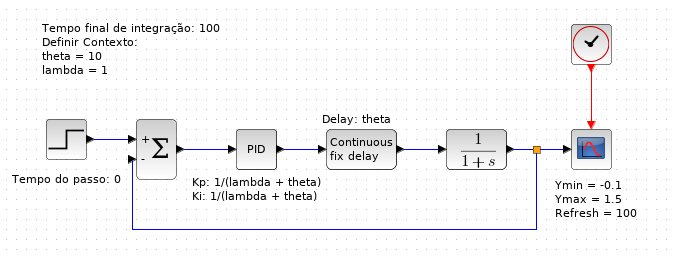

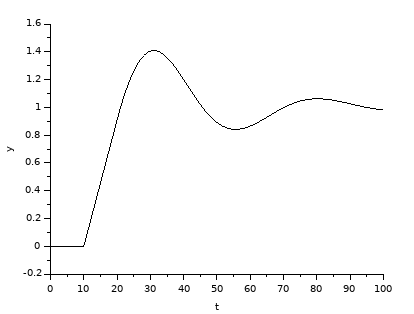

## Bibliografia

* B.W. Bequette. (2003). Process Control: Modeling, Design and Simulation. PHI Learning. Capítulo 6.
* C. Garcia (2017). Controle de Processos Industriais: Estratégias Convencionais. Volume 1, Blucher. Capítulo 8
* C.A. Smith, A. Corripio (2008). Princípios e Prática do Controle Automático de Processo. 3ª ed. LTC. Capítulos 7.